<a href="https://colab.research.google.com/github/Kona-O/topiary/blob/main/seed_to_alignment_beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seed to alignment

This notebook will walk through how to make a seed dataset for use in a topiary ASR study, offer a one-step seed-to-alignment function including definitions of the arguments used in the code, as well as code to work through each step of the pipeline individually with detailed explanations of what is going on behind the scenes.

## Construct a seed dataset

The first step in a topiary ASR calculation is constructing a seed dataset (Figure 2A). This
dataset defines protein family members of interest and the distribution of these proteins across species. Topiary uses this seed dataset to automatically find and download sequences to put into the alignment and, ultimately, evolutionary tree. An example for the LY86/LY96 protein family, a pair of closely related innate immune proteins, is shown in Table 1.

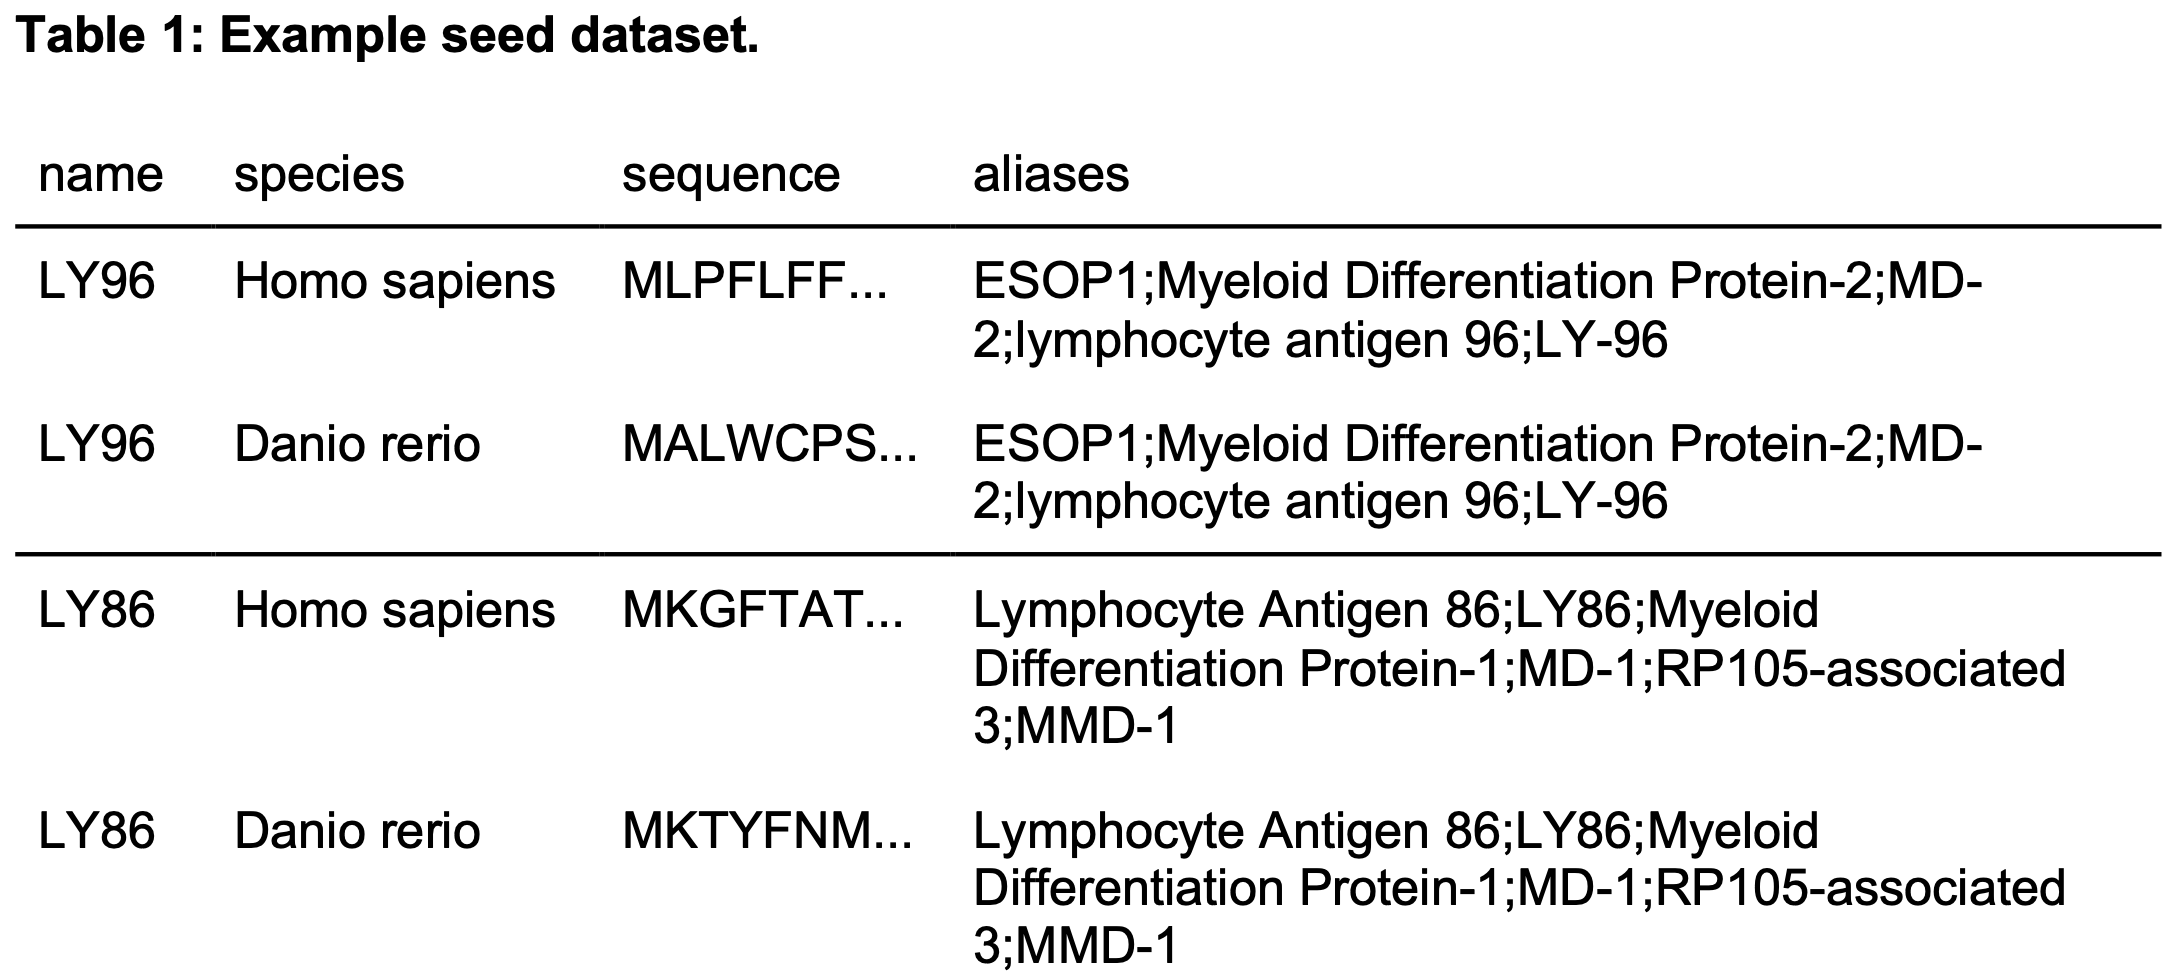
 
### To prepare the table:
1. **Choose the proteins of interest for your ASR calculation.** In our example, we included two paralogs: LY86 and LY96. The choice of proteins sets the scope of the evolutionary study. To study the deepest ancestor of LY86, we want to include LY96 as the relevant outgroup. In our experience, you generally want ~1-5 paralogs for a robust ASR investigation. As you add more paralogs, you need more sequences to resolve the evolutionary tree, slowing the calculation and—eventually—making the problem computationally intractable.
2. **Determine the taxonomic distribution of the protein family.** LY86 and LY96 are found across bony vertebrates (humans and bony fishes, but not sharks). If you are unsure of the taxonomic distribution of your proteins of interest, we discuss BLAST strategies for asking this question in the online topiary documentation.
3. **Choose two or three key species with well-annotated genomes that span the whole taxonomic distribution of your proteins of interest.** For LY86 and LY96, we selected humans and zebrafish, covering the breadth of species over which these proteins are found. Choosing humans and chimps would be a poor choice, as this covers only primates; even choosing humans and chickens would be non-optimal, as this covers only amniotes.
4. **Add sequences for each protein from your key species to the table.** These sequences are the basis for automatic dataset construction; they should therefore be high quality sequences: canonical rather than isoform, not hypothetical, not partial, etc. Our usual source for these seed sequences is Uniprot, but these can come from any source.
5. **Compile a list of aliases for each protein.** The same protein can have different names across different databases and species. Even in the same genome, gene nomenclature can be inconsistent. By using a human-curated list of aliases, topiary is more effective at identifying sequences that truly correspond to the paralogs of interest. Aliases can be found in many online databases. (A list of databases is given in the online documentation).

 






Run the code block below to import software necessary for the seed-to-alignment pipeline.

In [ ]:
# import necessary software
import topiary

from topiary._private import installed
from topiary._private import check

import numpy as np
import pandas as pd

import random
import string
import os
import shutil

Use the following code to load your seed dataset into a pandas dataframe and view it. To do this, change "name-of-your-seed-dataset.csv" to your file's name. This csv file must be in the same directory as this notebook on your local computer.

In [ ]:
seed_df = pd.read_csv("name-of-your-seed-dataset.csv")

seed_df

# Run the seed-to-alignment pipeline

At this point the seed dataset is ready to be passed to the topiary seed-to-alignment command-line script. This script uses BLAST to build a dataset of thousands of protein sequences (Figure 2B), does quality control, lowers redundancy, and then generates an alignment of sequences (Figure 2C). This generally takes less than an hour on a modern laptop. The slowest step in this pipeline is often the initial NCBI BLAST step. If your connection is unstable or the NCBI server proves too slow, topiary can BLAST against local databases or load previously saved BLAST XML results into this script. This script will generate and save a series of spreadsheets, each capturing the state of the dataset at each step in the pipeline. The final output consists of a single spreadsheet and a single fasta file holding the alignment.

In [ ]:
# Pipeline that takes a seed dataframe, BLASTs to find sequence hits,
# performs quality control, lowers alignment redundancy in a taxonomically
# informed fashion, and generates an alignment.

df = seed_to_alignment(seed_df,
                      out_dir=None,
                      seqs_per_column=1,
                      max_seq_number=500,
                      redundancy_cutoff=0.90,
                      worst_align_drop_fx=0.1,
                      sparse_column_cutoff=0.80,
                      align_trim=(0.05,0.95),
                      ncbi_blast_db=None,
                      local_blast_db=None,
                      blast_xml=None,
                      move_mrca_up_by=2,
                      local_recip_blast_db=None, 
                      min_call_prob=0.95,
                      partition_temp=1,
                      hitlist_size=5000,
                      e_value_cutoff=0.001,
                      gapcosts=(11,1),
                      num_ncbi_blast_threads=1,
                      num_local_blast_threads=-1,
                      restart=False,
                      overwrite=False,
                      keep_recip_blast_xml=False,
                      verbose=False)
topiary.write_dataframe(df,"alignment.csv")

### Argument definitions and default parameters for reference: 
----------
**seed_df** : *pandas.DataFrame or str*
<br> Dataframe with at least four columns: name, species, sequence, and aliases. See documentation on seed dataframes for details.
out_dir : str, optionaloutput directory. If not specified, create an output directory with the format "seed_to_alignment_{randomletters}".

**seqs_per_column** : *float, default=1*
<br> Aim to have this number of sequences per column in the key species sequences. (For example, if the key sequence is 100 amino acids long, seqs_per_column=1 would aim for 100 sequences; 2 would aim for 200 sequences).

**max_seq_number** : *int, default=500*
<br> Maximum number of sequences to get, regardless of seqs_per_column and key sequence length.

**redundancy_cutoff** : *float, default=0.90*
<br> Merge sequences from closely related species with sequence identity above cutoff.

**worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.

**sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than sparse_column_cutoff sequences.

**align_trim** : *tuple, default=(0.05,0.95)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. Interpreted like a slice, but with percentages. (0.0,1.0) would not trim; (0.05,0,98) would trim the first 0.05 off the front and the last 0.02 off the back.
<br>
<br>

**ncbi_blast_db** : *str, optional*
<br> NCBI BLAST database to use. (If ncbi_blast_db, local_blast_db and blast_xml are all None, ncbi_blast_db is automatically set to "nr").

**local_blast_db** : *str, optional*
<br> Local BLAST database to use.

**blast_xml** : *str or list, optional*
<br> Previously generated BLAST .xml files to load. This argument can be:
+ single .xml file (str)
+ list of .xml files (list of str)
+ directory (str). Code will grab all .xml files in the directory.
<br>

**move_mrca_up_by** : *int, default=2*
<br> When inferring the phylogenetic context from the seed dataframe, get the most recent common ancestor of the seed species, then find the taxonomic rank "move_mrca_up_by" levels above that ancestor. For example, if the key species all come from marsupials (Theria) and move_mrca_up_by == 2, the context will be Amniota (Theria -> Mammalia -> Amniota).

**local_recip_blast_db** : *str, optional*
<br> Local BLAST database to use for reciprocal BLAST. If None, construct a reciprocal BLAST database by downloading the proteomes of the key species from the NCBI.

**min_call_prob** : *float, default=0.95*
<br> Hits from all paralogs that yield a regular expression match to one of the aliases from the seed dataframe are weighted by their relative BLAST bit scores. Each paralog is assigned a relative probability. This cutoff is the minimum probability the best paralog match must have to result in a paralog call. Value should be between 0 and 1 (not inclusive), where increasing min_call_prob increases the stringency.

**partition_temp** : *float, default=1*
<br> When calculating posterior probability of the reciprocal BLAST paralog call, use this for weighting: 2^(bit_score/partition_temp). partition_temp should be a float > 0. A higher value corresponds to a higher stringency. (The bit score difference between the best hit and the bit scores of other hits would have to be higher to be significant). This is a minimum value. It may be adjusted automatically to avoid numerical problems in the calculation.
<br>
<br>
**hitlist_size** : *int, default=5000*
<br> Download only the top hitlist_size hits in initial BLAST.

**e_value_cutoff** : *float, default=0.001*
<br> Only take hits with e_value better than e_value_cutoff in initial BLAST
gapcost : tuple, default=(11,1) BLAST gapcosts (length 2 tuple of ints) in initial blast
num_ncbi_blast_threads : int, default=1 number of threads to use for NCBI BLAST. -1 means use all available. (Multithreading rarely speeds up remote BLAST).

**num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local BLAST. -1 means all available.
<br>
<br>
**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with overwrite.

**overwrite** : *bool, default=False*
<br> Overwrite out_dir if it already exists. Incompatible with restart.

**keep_recip_blast_xml** : *bool, default=False*
<br> Whether or not to keep raw BLAST .xml output.

**verbose** : *bool, default=False*
<br> Verbosity of output.
<br>
<br>
Returns
----------
**topiary_dataframe** : *pandas.DataFrame*
<br> Topiary dataframe with aligned, quality-controlled sequences.

----------

# Inspect and edit alignment

At this point the alignment is almost ready to be passed to the topiary alignment-to-ancestors command-line script.

Before reconstructing a phylogenetic tree and ancestors, we strongly recommend inspecting and possibly editing the alignment (Figure 2C). There are a variety of pieces of software for visualizing alignments, including AliView (Larsson A, 2014), JALView (Waterhouse AM, 2009), and MEGA (Tamura K, 2021). We generally use AliView because of its balance of utility and simplicity.
There are differing views on whether to manually edit an alignment (Catanach TA, 2019; Morrison DA, 2006); the topiary package allows a user to manually edit their alignment but does not require it. We generally recommend making a few adjustments to alignments. Importantly, if we edit an alignment, we publish the alignment as supplemental material in the resulting manuscript so others can reproduce our work. We use four “moves” (listed below and shown in Figure 5 in manuscript).

1. Trim variable-length N- and C-terminal regions from the alignment (Figure 5A). A huge number of sparse and variable columns will slow evolutionary analyses and will generally not provide enough signal to be reconstructed with confidence.
2. Delete sequences with long, unique insertions or deletions (indels) (Figure 5B). Indels can lead to alignment ambiguity around flanking regions. Further, they provide no information for most ancestors, most of whom do not have the indel, while increasing the computational cost of the phylogenetic analysis. Note, we do not make internal edits to sequences (say, by deleting a long lineage-specific insertion) as this becomes difficult to track or justify upon future realignment steps.
3. Delete lineage-specific duplicates, selecting the sequence with the greatest sequence coverage (Figure 5C). The pipeline generally does a good job of deleting sequences in this class; however, if such sequences slip through, we delete them from the alignment.
Because trying to align long, unique, and variable sequences can affect the alignment of other sequences, we generally use Muscle5 to re-align the full MSA after we perform steps 1-3. This can be done directly from AliView. (We will often iterate through steps 1-3 and full alignment several times).
4. Finally, after we are satisfied that we have sequences of reasonable length and composition, we carefully inspect the alignment and may correct “obvious” local misalignments (Figure 5D). In our view, an edit like that shown in Figure 5D makes the alignment a more accurate description of sequence homology than otherwise; however, we recognize that this is subjective and difficult to quantify. As noted above, we publish our alignment with our final ancestors to allow others to assess our judgement and promote reproducibility.





Once the alignment is finalized, it can be read back into the topiary spreadsheet with the command line script *topiary-fasta-into-dataframe*.

In [ ]:
topiary-fasta-into-dataframe